In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data._utils.collate import default_convert
import torch.optim as optim
import tqdm
import numpy as np

from model import HangmanTransformer, HangmanTransformerDirect
torch.manual_seed(42)

1. current model output doesnt make much sense. what does probability at each location represent
2. if its the p dist of letters at that location then final label cant be prob of missing letter

In [2]:
train_pth = ('data/processed_data/train_x.npy', 'data/processed_data/train_y.npy')
test_pth = ('data/processed_data/test_x.npy', 'data/processed_data/test_y.npy')
vocab = '*abcdefghijklmnopqrstuvwxyz_'

block_size = 32  #T
batch_size = 256 #B
embed_size = 128 #C

vocab_size = 28
n_head = 8
n_layer = 2
output_size = 26

dropout = 0

device = torch.device('mps')


In [3]:
class WordDataset(Dataset):
    def __init__(self, pths):
        self.x = torch.from_numpy(np.load(pths[0]))
        self.y = torch.from_numpy(np.load(pths[1]))

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        idx = idx
        return self.x[idx], self.y[idx]

In [4]:
train_ds = WordDataset(train_pth)
test_ds = WordDataset(test_pth)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
model = HangmanTransformer(vocab_size, embed_size, block_size, n_head, n_layer, output_size, dropout, device)

In [136]:
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()
        self.bce = nn.BCELoss(reduction='mean')

    def forward(self, p, y):
        loss = self.bce(p, y) - self.bce(y, y)

        return loss

In [137]:
model.to(device)

loss_func = LossFunction()

optimizer = optim.AdamW(model.parameters(), lr=0.005)
lmbda = lambda epoch: 0.5
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

n_epoch = 200
lr_update_steps = 8000
val_calc_step = 10

n_step = 0
train_loss = 0
val_loss = 0

history = []


for epoch in range(n_epoch):
    with tqdm.tqdm(train_dl, unit='Batch') as train_tepoch:
        for x, y in train_tepoch:
            n_step += 1
            train_tepoch.set_description(f"Epoch {epoch+1}: Training")

            x = x.to(device)
            y = y.float().to(device)

            optimizer.zero_grad()
            p = model(x)
            loss = loss_func(p, y)
            loss.backward()
            optimizer.step()

            train_loss = loss.item()

            if (n_step-1)%val_calc_step == 0:
                model.eval()

                x, y = next(iter(test_dl))
                x = x.to(device)
                y = y.float().to(device)

                p = model(x)
                loss = loss_func(p, y)
                val_loss = loss.item()

                model.train()
            
            if (n_step%lr_update_steps == 0):
                scheduler.step()

            train_tepoch.set_postfix(train_loss=train_loss, val_loss=val_loss)
            history.append([n_step, train_loss, val_loss])

Epoch 13: Training:  95%|█████████▍| 370/390 [00:31<00:01, 11.57Batch/s, train_loss=0.198, val_loss=0.226]


KeyboardInterrupt: 

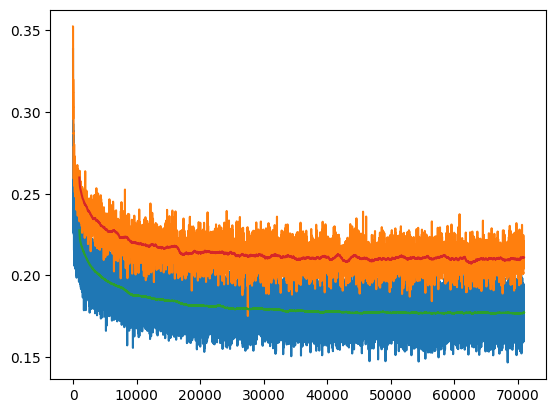

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(history, columns=['iter', 'train_loss', 'val_loss'])

plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

plt.plot(history['train_loss'].rolling(window=1000).mean())
plt.plot(history['val_loss'].rolling(window=1000).mean())
plt.show()